## Title
Introduction to Autoencoders using MNIST

## Description :
The goal of the exercise is to use an autoencoder to first compress hand-written digit images from the MNIST dataset down to lower-dimensional representations and then expand them back to the original images.

Your final output will look similar to the image below: 

<img src="../fig/fig1.png" style="width: 500px;">

## Instructions:
- Load the MNIST dataset with the `mnist.load_data()` function provided by keras. Load the images in two separate lists, `x_train` and `x_test`.
- Create the first part of the autoencoder - the encoder model.
    - The encoder model compresses the input image down to a lower dimensional latent space
- Next create the 2nd half of the autoencoder - the decoder.
    - The decoder expands an image representation in the latent space back to the full dimensions of the original input image.
- Normalize your data by dividing each pixel by 255.
- Finally, we combine the encoder and decoder into the autoencoder.
- The autoencoder shrinks the image down to the latent space representation and then expands it again to the original dimensions.
- Visualize the model predictions on the test set after every epoch using the helper code given.
- You can experiment with the different `latent_size`, `layer_size` and `regularization`.

## Hints: 

More on Keras Functional API <a href="https://www.tensorflow.org/guide/keras/functional" target="_blank">here</a>. 

<a href="https://keras.io/guides/sequential_model/" target="_blank">keras.compile()</a> Compiles the layers into a network.

<a href="https://keras.io/guides/sequential_model/" target="_blank">keras.Sequential()</a> Models a sequential neural network.

<a href="https://keras.io/api/layers/core_layers/dense/" target="_blank">keras.Dense()</a> A regular densely-connected NN layer.

<a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten" target="_blank">layers.Flatten()</a> Flattens the input. Does not affect the batch size.

<a href="https://www.tensorflow.org/api_docs/python/tf/keras/Input" target="_blank">tf.keras.Input()</a> Used to instantiate a Keras tensor.

**NOTE:** To keep things simple we will use dense layers, so no convolutions here.

In [1]:
# import required libraries

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Input, Flatten, Reshape
from tensorflow.keras import models
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from IPython import display 
import numpy as np

%matplotlib inline

2023-08-31 15:22:33.781417: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-31 15:22:33.923900: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-31 15:22:33.925400: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-31 15:22:34.895905: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


image shape: (28, 28) and random pixel value is 0.09411764705882353


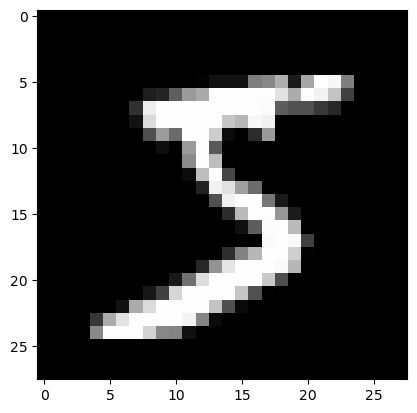

In [2]:
### edTest(test_normalize) ###
# First we load in the MNIST dataset.

# Do not fill in the blank space
(x_train, _), (x_test, _) = mnist.load_data()


# We will only take 4000 data points from the original dataset to demonstrate the autoencoders
sample_size = 4000 
x_train = x_train[:sample_size]
x_test = x_test[:sample_size]

# We normalize the pixel data (i.e divide by 255)

x_train = x_train/255.0
x_test = x_test/255.0

# We print image dimensions to confirm 
print(f'image shape: {x_train[0].shape} and random pixel value is {x_train[0][20][10]}')

# We also plot example image from x_train
plt.imshow(x_train[0], cmap = "gray")
plt.show()

In [10]:
### edTest(test_model_encoder) ###
# Now we create the encoder model to take compress each image down to a lower dimensional latent space.

# pick a size for the latent dimension like 32
latent_size = 2

# Note how sequential models can also be passed a list of layers

# This can be more concise than using add()
model_1 = models.Sequential(name='Encoder')

# add a flatten layer to convert image of size (28,28) to 784
# don't forget to include the `input_shape` argument
model_1.add(Flatten(input_shape = (28,28)))

# add a dense layer with 128 neurons
model_1.add(Dense(units = 128))

# add another dense layer with 64 neurons
model_1.add(Dense(units = 64))

# Finally add the last dense layer with latent_size number of neurons
model_1.add(Dense(units = latent_size))

# Take a quick look at the model summary
model_1.summary()

Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_9 (Dense)             (None, 128)               100480    
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 2)                 130       
                                                                 
Total params: 108866 (425.26 KB)
Trainable params: 108866 (425.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
### edTest(test_model_decoder) ###
# Now we create the decoder model to take compress each image down to a lower dimensional latent space.
model_2 = models.Sequential(name='Decoder')

# add a dense layer with 64 neurons
model_2.add(Dense(units=64,input_shape = (2,)))

# add a dense layer with 128 neurons
model_2.add(Dense(units = 128))

# add a dense layer with 784 neurons and especially choose an appropriate activation function
model_2.add(Dense(units = 784))

# finally reshape it back to size 28,28
model_2.add(Reshape((28,28)))

# Take a quick look at the model summary
model_2.summary()

Model: "Decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 64)                192       
                                                                 
 dense_16 (Dense)            (None, 128)               8320      
                                                                 
 dense_17 (Dense)            (None, 784)               101136    
                                                                 
 reshape_3 (Reshape)         (None, 28, 28)            0         
                                                                 
Total params: 109648 (428.31 KB)
Trainable params: 109648 (428.31 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
### edTest(test_model_autoencoder) ###
# To build autoencoders, we will use the keras 'functional api'
# read more here -> https://www.tensorflow.org/guide/keras/functional

# define an input of the dimension of the image
img = Input(shape=(28,28))

# Use the 'encoder' i.e model_1 from above to get a variable `latent_vector`
latent_vector = model_1(img)

# Use the 'decoder' i.e model_2 from above to get the output variable
output = model_2(latent_vector)


# using functional api to define autoencoder model
autoencoder = Model(inputs = img, outputs = output)

# choose an appropriate loss function for 'reconstruction error' and optimizer = nadam
autoencoder.compile(loss = "mean_squared_error", metrics = ["accuracy"], optimizer = "nadam")

# Take a quick look at the model summary
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 Encoder (Sequential)        (None, 2)                 108866    
                                                                 
 Decoder (Sequential)        (None, 28, 28)            109648    
                                                                 
Total params: 218514 (853.57 KB)
Trainable params: 218514 (853.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


1/1 [==============================] - 0s 54ms/step


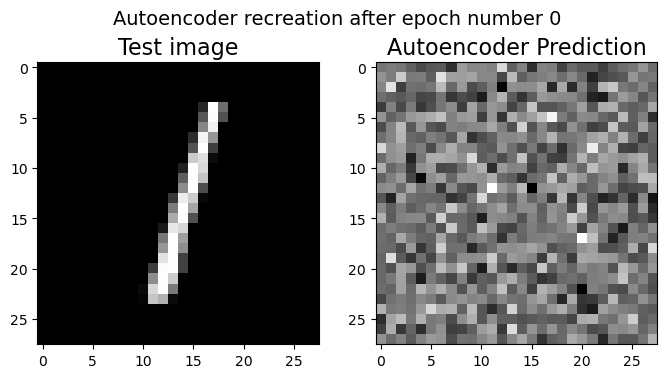

1/1 [==============================] - 0s 11ms/step


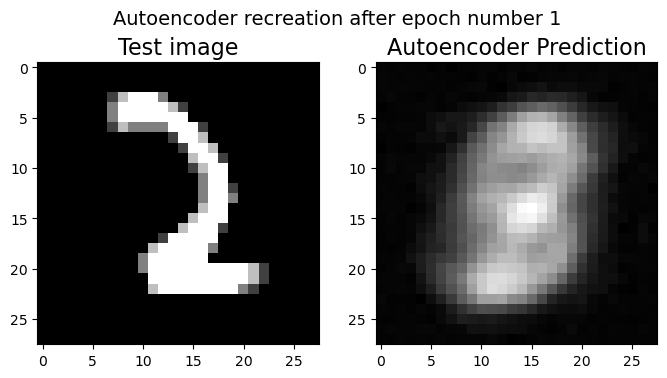

1/1 [==============================] - 0s 11ms/step


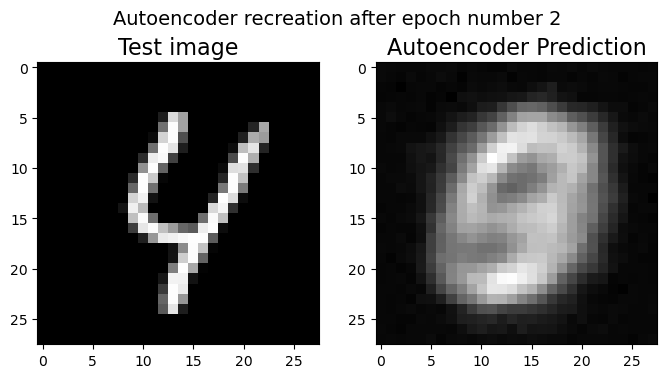

1/1 [==============================] - 0s 12ms/step


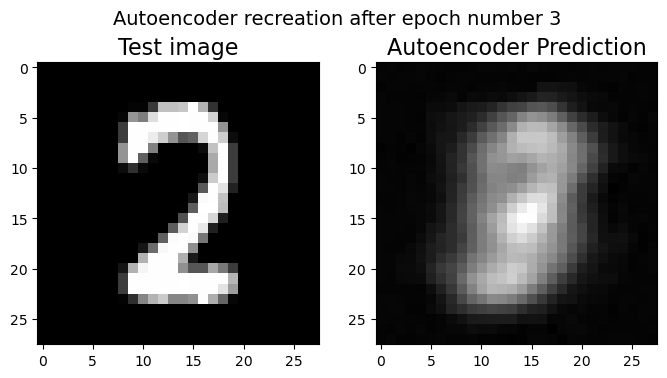

1/1 [==============================] - 0s 12ms/step


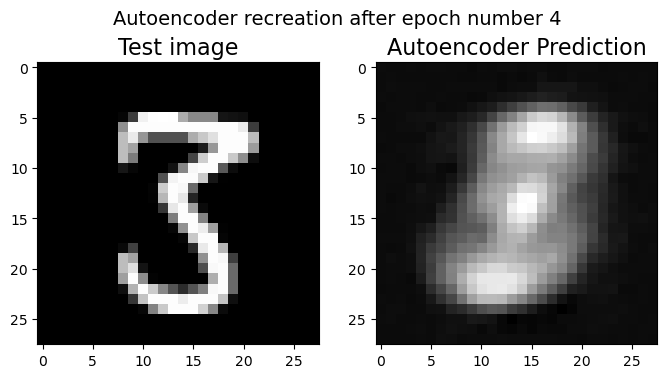

1/1 [==============================] - 0s 11ms/step


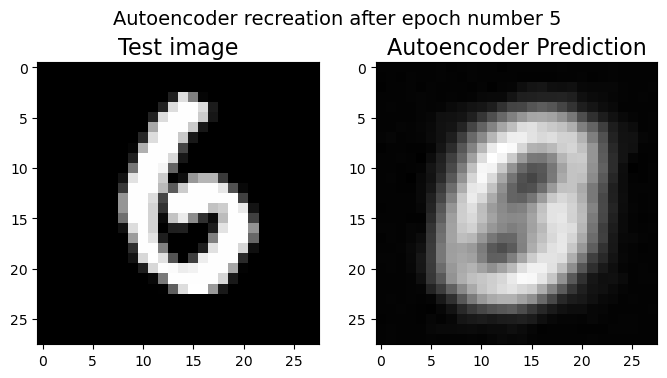

1/1 [==============================] - 0s 11ms/step


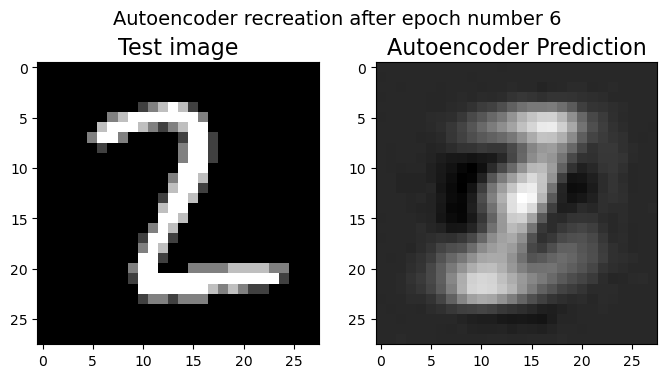

1/1 [==============================] - 0s 11ms/step


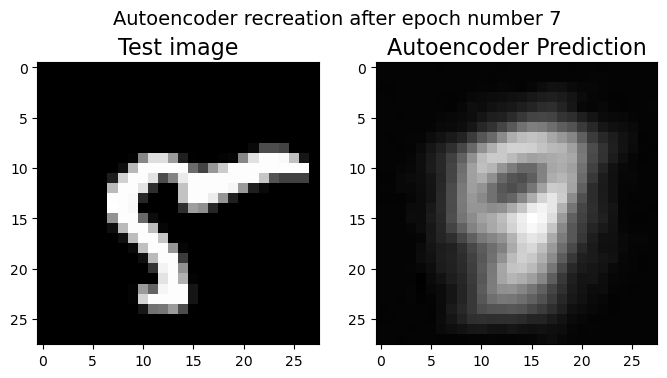

1/1 [==============================] - 0s 11ms/step


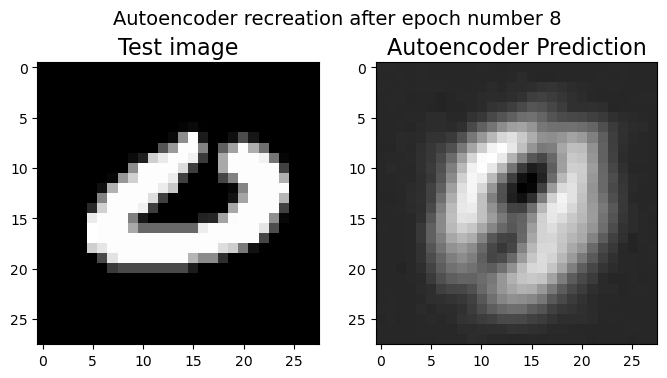

1/1 [==============================] - 0s 12ms/step


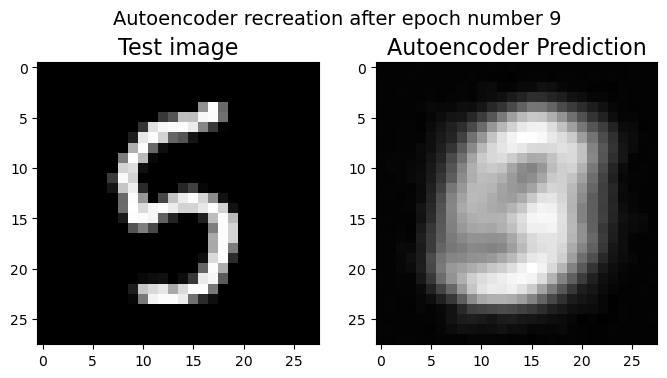

1/1 [==============================] - 0s 12ms/step


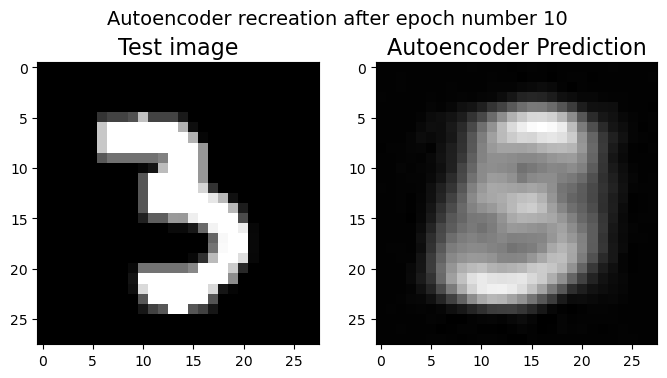

125/125 [==============================] - 0s 3ms/step - loss: 0.0554 - accuracy: 0.1009 - val_loss: 0.0550 - val_accuracy: 0.0989


In [15]:
# # You can train for 10 or more epochs to see how well our autoencoder model performs
epochs = 10

for i in range(epochs+1):
# Note: epoch 0 is before any fitting
    fig, axs = plt.subplots(1, 2,figsize = (8,4))
    sample_x = x_test[np.random.choice(x_test.shape[0])]
    axs[0].imshow(sample_x,cmap = "gray")
    axs[0].set_title('Test image',fontsize = 16)
    axs[1].imshow(autoencoder.predict(sample_x.reshape(1,28,28))[0],cmap = "gray")
    # predict(shape includes the batch size)
    
    axs[1].set_title('Autoencoder Prediction',fontsize = 16);
    fig.suptitle(f'Autoencoder recreation after epoch number {i}',fontsize =14)
    plt.show()
    
    # specify predictors and targets for train and validation and train for an epoch
    
    autoencoder.fit(x=x_train,
                y=x_train,
                validation_data=(x_test, x_test))
    # default epoch is 1
    # y = x_train!!!!!!!!!!!

## Mindchow 🍲

Go back and change the `latent_space` dimension to a lower value like 2. Does your autoencoder's reconstructions become better or worse? Why?

*Your answer here*